In [39]:
from ellipse import LsqEllipse
import numpy as np
import pandas as pd
from tqdm import tqdm
import pdb
import math
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os

In [42]:
Data = pd.read_excel(r'\\sil3\data\Large_scale_mapping_NP\Experiment_Excel.xlsx')
Data

,Animal_ID,Species,Experiment_date,Base_path,Exp_name,Insertion,Digital_channel,Diode_channel,Camera_bit,Sync_bit,...,Remove_Spk_duplicates,Manual_curation,Histology,ResponseU,Matlab3Dcoor,Screen_Coor_XYZ,Eye_Coor_XYZ,Camera_Coor_XYZ,DLC_analysis,Phy_goodN
0,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,1,16,0,7,0,...,yes,no,"Slices, photos","1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 17, 20, 22, ...","39.74, 49, -21.44",NaN,NaN,NaN,NaN,NaN
1,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,2,16,0,7,0,...,yes,no,"Slices, photos","2,23,25,28,20,22,25,28,29,32,34,36,37,38,39,40","41.72, 53.4,- 20.94",NaN,NaN,NaN,NaN,NaN
2,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,3,16,0,7,0,...,yes,no,"Slices, photos","3,7,10,14,15,17,18,19,20,26,33,46,50","42.8, 48.82, -22.05",NaN,NaN,NaN,NaN,NaN
3,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,4,16,0,7,0,...,yes,no,"Slices, photos","5,8,13","36.6, 49.9, -21.4",NaN,NaN,NaN,NaN,NaN
4,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,5,16,0,7,0,...,yes,no,"Slices, photos","35,89","41.85, 59.2, -21,8",NaN,NaN,NaN,NaN,NaN
5,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,6,16,0,7,0,...,yes,no,"Slices, photos","11,13,14,21,29,31,32,28,45,80,81,82","34.51, 51.4, -21.38",NaN,NaN,NaN,NaN,NaN
6,PV103,P. vitticeps,12_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV103_Experiment_12_6_23,7,16,0,7,0,...,yes,no,"Slices, photos","6,18,25,29,30,32,36,37,38,44,57,78,82,84,89","35.21, 44.18,- 23.85",NaN,NaN,NaN,NaN,NaN
7,PV27,P. vitticeps,25_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV27_Experiment_25_6_23,2,16,0,7,0,...,yes,no,"Slices, photos","16,22,28,29,31,34,36,37,38,49,58,59,62,68,73,7...","43.12, 57.25, -21.31",NaN,NaN,NaN,NaN,NaN
8,PV27,P. vitticeps,25_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV27_Experiment_25_6_23,3,16,0,7,0,...,yes,no,"Slices, photos","10,11,18,22,26,28,32,46,49,50,54,55,56,57,60,6...","39.18, 57.17, -21.18",NaN,NaN,NaN,NaN,NaN
9,PV27,P. vitticeps,25_6_23,\\132.66.45.127\data\Large_scale_mapping_NP\\I...,PV27_Experiment_25_6_23,4,16,0,7,0,...,yes,no,"Slices, photos",NaN,"38.9, 59.39, -21.54",NaN,NaN,NaN,NaN,NaN


In [43]:
#Ellipse fitting function
def eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param uncertainty_thr: The confidence P value to use as a threshold for datapoint validity in the analysis
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame

    """
    # import the dataframe and convert it to floats
    #data = df.iloc[:100]
    data = dlc_video_analysis_csv.iloc[1:].apply(pd.to_numeric)

    
    # sort the pupil elements to dfs: x and y, with p as probability
    pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])
    
    # get X coords
    pupil_xs_before_flip = data[pupil_elements[np.arange(0, len(pupil_elements), 3)]]
    
    # flip the data around the midpoint of the x-axis (shooting the eye through a camera flips right and left)
    pupil_xs = pupil_xs_before_flip #320 * 2 - pupil_xs_before_flip
    
    # get Y coords (no need to flip as opencv conventions already start with origin at top left of frame
    # and so, positive Y is maintained as up in a flipped image as we have)
    pupil_ys = data[pupil_elements[np.arange(1, len(pupil_elements), 3)]]
    pupil_ps = data[pupil_elements[np.arange(2, len(pupil_elements), 3)]]
    
    # rename dataframes for masking with p values of bad points:
    pupil_ps = pupil_ps.rename(columns=dict(zip(pupil_ps.columns, pupil_xs.columns)))
    pupil_ys = pupil_ys.rename(columns=dict(zip(pupil_ys.columns, pupil_xs.columns)))
    good_points = pupil_ps > uncertainty_thr
    pupil_xs = pupil_xs[good_points]
    pupil_ys = pupil_ys[good_points]
    
    # Do the same for the edges
    edge_elements = np.array([x for x in data.columns if 'edge' in x])
    edge_xs_before_flip = data[edge_elements[np.arange(0, len(edge_elements), 3)]]
    edge_xs = 320 * 2 - edge_xs_before_flip
    edge_ys = data[edge_elements[np.arange(1, len(edge_elements), 3)]]
    edge_ps = data[edge_elements[np.arange(2, len(edge_elements), 3)]]
    edge_ps = edge_ps.rename(columns=dict(zip(edge_ps.columns, edge_xs.columns)))
    edge_ys = edge_ys.rename(columns=dict(zip(edge_ys.columns, edge_xs.columns)))
    # e = edge_ps < uncertainty_thr
    
    # work row by row to figure out the ellipses
    ellipses = []
    goodFrames = []
    Xs = []
    caudal_edge_ls = []
    rostral_edge_ls = []
    for row in tqdm(range(1, len(data) - 1)):
        # first, take all the values, and concatenate them into an X array
        x_values = pupil_xs.loc[row].values
        y_values = pupil_ys.loc[row].values
        X = np.c_[x_values, y_values]
    
        # now, remove nan values, and check if there are enough points to make the ellipse
        X = X[~ np.isnan(X).any(axis=1)]

        #pdb.set_trace()
    
        # if there are enough rows for a fit, make an ellipse
        Xs.append(X)
        if X.shape[0] > 5:
            #pdb.set_trace()
            goodFrames.append(row)
            el = LsqEllipse().fit(X)
            center, width, height, phi = el.as_parameters()
            center_x = center[0]
            center_y = center[1]
            ellipses.append([center_x, center_y, width, height, phi])
        else:
            ellipses.append([np.nan, np.nan, np.nan, np.nan, np.nan])
    
        # caudal_edge = [
        #     float(data['Caudal_edge'][row]),
        #     float(data['Caudal_edge.1'][row])
        # ]
        # rostral_edge = [
        #     float(data['Rostral_edge'][row]),
        #     float(data['Rostral_edge.1'][row])
        # ]
        # caudal_edge_ls.append(caudal_edge)
        # rostral_edge_ls.append(rostral_edge)
    
    ellipse_df = pd.DataFrame(columns=['center_x', 'center_y', 'width', 'height', 'phi'], data=ellipses)
    
    
    a = np.array(ellipse_df['height'][:])
    b = np.array(ellipse_df['width'][:])
    ellipse_size_per_frame = a * b * math.pi
    ellipse_df['ellipse_size'] = ellipse_size_per_frame
    #ellipse_df['rostral_edge'] = rostral_edge_ls
    #ellipse_df['caudal_edge'] = caudal_edge_ls
    
    print(f'\n ellipses calculation complete')
    return ellipse_df, Xs, goodFrames

In [45]:
for ex in np.arange(48, 53): #Select experiment in rows
    print(ex)
    
    #directory = os.path.join(Data['Base_path'][ex],Data['Exp_name'][ex],"Insertion"+str(Data['Insertion'][ex]),"Processed_Video")
    directory = Data['Eye_video_dir'][ex]
    all_files = os.listdir(directory)
    filtered_files = [file for file in all_files if file.endswith('.csv') and 'filtered' in file and 'thr' not in file 
                      and "_"+str(Data['Insertion'][ex])+"_" in file]
    print(filtered_files)
    dlc_video_analysis_path =  os.path.join(directory,str(filtered_files[0]))
    uncertainty_thr = 0.3
    dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path,skiprows=1)

    #Run ellipse fitting
    [ellipse_df,Xs,goodFrames] = eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr)

    print(ellipse_df.shape)
    print(f'Total frames {Data['Animal_ID'][ex]+"_"+str(Data['Insertion'][ex])} = {dlc_video_analysis_csv.shape[0]}')
    print(f'Good frames {Data['Animal_ID'][ex]+"_"+str(Data['Insertion'][ex])} = {len(goodFrames)}')
    print(f'Percentage of Good frames {Data['Animal_ID'][ex]+"_"+str(Data['Insertion'][ex])} = {len(goodFrames)/dlc_video_analysis_csv.shape[0]}')
    #Save results
    ## Save results:
    ellipse_df.to_csv(os.path.join(directory,str(filtered_files[0].removesuffix(".csv"))+str(f'_Eye_ellipse_thr_{uncertainty_thr}.csv')), index=False)
    dfGF = pd.DataFrame(goodFrames, columns=['Values'])    
    dfGF.to_csv(os.path.join(directory,str(filtered_files[0].removesuffix(".csv"))+str(f'_good_frames_thr_{uncertainty_thr}.csv')), index=False)




48
['PV97_1_Camera1_20250121-163645DLC_Resnet50_EyeTracking3Oct3shuffle4_snapshot_200_filtered.csv']


C:\Users\Mark_S13\AppData\Local\Temp\ipykernel_30000\3408589478.py:12: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path,skiprows=1)
100%|████████████████████████████████████████████████████████████████████████| 488041/488041 [02:11<00:00, 3715.56it/s]



 ellipses calculation complete
(488041, 6)
Total frames PV97_1 = 488044
Good frames PV97_1 = 488041
Percentage of Good frames PV97_1 = 0.9999938530132529
49
['PV97_2_Camera1_20250121-192657DLC_Resnet50_EyeTracking3Oct3shuffle4_snapshot_200_filtered.csv']


C:\Users\Mark_S13\AppData\Local\Temp\ipykernel_30000\3408589478.py:12: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path,skiprows=1)
100%|████████████████████████████████████████████████████████████████████████| 251022/251022 [01:07<00:00, 3718.87it/s]



 ellipses calculation complete
(251022, 6)
Total frames PV97_2 = 251025
Good frames PV97_2 = 251013
Percentage of Good frames PV97_2 = 0.9999521959964147
50
['PV97_3_Camera1_20250122-114320DLC_Resnet50_EyeTracking3Oct3shuffle4_snapshot_200_filtered.csv']


C:\Users\Mark_S13\AppData\Local\Temp\ipykernel_30000\3408589478.py:12: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path,skiprows=1)
100%|████████████████████████████████████████████████████████████████████████| 455796/455796 [02:03<00:00, 3688.34it/s]



 ellipses calculation complete
(455796, 6)
Total frames PV97_3 = 455799
Good frames PV97_3 = 455796
Percentage of Good frames PV97_3 = 0.999993418151422
51
['PV97_4_Camera1_20250122-142459DLC_Resnet50_EyeTracking3Oct3shuffle4_snapshot_200_filtered.csv']


C:\Users\Mark_S13\AppData\Local\Temp\ipykernel_30000\3408589478.py:12: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path,skiprows=1)
100%|████████████████████████████████████████████████████████████████████████| 281670/281670 [01:17<00:00, 3651.90it/s]



 ellipses calculation complete
(281670, 6)
Total frames PV97_4 = 281673
Good frames PV97_4 = 281652
Percentage of Good frames PV97_4 = 0.9999254454633565
52
['PV97_5_Camera1_20250123-110910DLC_Resnet50_EyeTracking3Oct3shuffle4_snapshot_200_filtered.csv']


C:\Users\Mark_S13\AppData\Local\Temp\ipykernel_30000\3408589478.py:12: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path,skiprows=1)
100%|████████████████████████████████████████████████████████████████████████| 468004/468004 [02:07<00:00, 3674.98it/s]



 ellipses calculation complete
(468004, 6)
Total frames PV97_5 = 468007
Good frames PV97_5 = 467755
Percentage of Good frames PV97_5 = 0.9994615465153299


In [28]:
Data['Animal_ID'][ex]+"_"+str(Data['Insertion'][ex])


'SA8_5'

In [41]:
#dlc_video_analysis_path1 =  r"C:\Users\MarkS9\Desktop\HeadFixedEyeTrack2-Simon-2024-10-02\EyeTracking3-Simon-2024-10-03\videos\PV35_Insertion4_Camera1_20240821-115142DLC_Resnet50_EyeTracking3Oct3shuffle1_snapshot_200.csv"

#dlc_video_analysis_path =  r"C:\Users\MarkS9\Desktop\HeadFixedEyeTrack2-Simon-2024-10-02\EyeTracking3-Simon-2024-10-03\videos\pv35_Insertion2_Camera1_20240819-123015DLC_Resnet50_EyeTracking3Oct3shuffle1_snapshot_200.csv"
#dlc_video_analysis_path = r"C:\Users\MarkS9\Desktop\HeadFixedEyeTrack2-Simon-2024-10-02\EyeTracking3-Simon-2024-10-03\videos\pv35_Insertion3_Camera1_20240819-152541DLC_Resnet50_EyeTracking3Oct3shuffle1_snapshot_200.csv"
#dlc_video_analysis_path = r"W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\EnhancedVids\EnhancedContrast-SA8_7_11_24_3_Camera1_20241111-162540croppedDLC_Resnet50_EyeTracking3Oct3shuffle2_snapshot_200.csv"
#dlc_video_analysis_path = r"W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\EnhancedVids\SA8_insertion5_Camera1_20241126-160054DLC_Resnet50_EyeTracking3Oct3shuffle2_snapshot_200_filtered.csv"
dlc_video_analysis_path = r"W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\EnhancedVids\EnhancedContrast-SA8_7_11_24_1_Camera1_20241107-143003croppedDLC_Resnet50_EyeTracking3Oct3shuffle2_snapshot_200.csv"
uncertainty_thr = 0.80
dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path,skiprows=1)
#dlc_video_analysis_csv1 = pd.read_csv(dlc_video_analysis_path1)
#dlc_video_analysis_csv.columns = dlc_video_analysis_csv.iloc[0]
#dlc_video_analysis_csv = dlc_video_analysis_csv[1:].reset_index(drop=True)
#dlc_video_analysis_csv1 = pd.read_csv('ExampleDFsimon.csv')

C:\Users\MarkS9\AppData\Local\Temp\ipykernel_10504\4107581291.py:9: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  dlc_video_analysis_csv = pd.read_csv(dlc_video_analysis_path,skiprows=1)


In [44]:
uncertainty_thr = 0.8

In [22]:
dlc_video_analysis_csv

,bodyparts,Pupil_12,Pupil_12.1,Pupil_12.2,Pupil_6,Pupil_6.1,Pupil_6.2,Pupil_3,Pupil_3.1,Pupil_3.2,...,Pupil_11.2,Pupil_7,Pupil_7.1,Pupil_7.2,Pupil_5,Pupil_5.1,Pupil_5.2,Pupil_2,Pupil_2.1,Pupil_2.2
0,coords,x,y,likelihood,x,y,likelihood,x,y,likelihood,...,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood
1,0,293.22665,192.09506,0.17483498,299.76508,246.68791,1.0,327.19644,210.61617,0.31084463,...,0.19807263,287.0406,241.14807,0.89779395,316.5068,245.35686,0.39031398,319.10202,199.70432,0.2185246
2,1,293.22702,192.09653,0.17487614,299.7655,246.69048,1.0,327.1976,210.61717,0.3107848,...,0.19803166,287.04016,241.15065,0.89774346,316.5062,245.35855,0.39037716,319.10312,199.70589,0.21857195
3,2,293.25983,192.08237,0.17436416,299.7552,246.6849,1.0,327.24826,210.68066,0.3069846,...,0.1971627,287.0482,241.14319,0.8976288,316.494,245.36337,0.38705954,319.1899,199.69864,0.21579768
4,3,293.25983,192.08237,0.17436416,299.7552,246.6849,1.0,327.24826,210.68066,0.3069846,...,0.1971627,287.0482,241.14319,0.8976288,316.494,245.36337,0.38705954,319.1899,199.69864,0.21579768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726974,726973,365.97864,195.30435,0.017915,348.26236,210.21904,0.023093,366.93854,198.21358,0.026513,...,0.014536,335.74918,210.87355,0.031646,380.26913,215.17044,0.017081,369.07806,199.50854,0.026405
726975,726974,365.89505,195.25595,0.017526,348.71606,210.08041,0.018532,367.3157,197.94063,0.028105,...,0.014456,336.00244,210.86092,0.031894,380.2719,215.44048,0.017357,369.39423,199.2027,0.026193
726976,726975,365.9707,195.44394,0.017199,348.57172,210.11966,0.01947,367.08154,198.19823,0.025325,...,0.01447,335.93335,210.89561,0.030951,380.14395,215.38844,0.017371,369.14896,199.52084,0.024676
726977,726976,365.9268,195.50587,0.015984,348.38913,210.16019,0.021056,366.95023,198.26367,0.023774,...,0.01382,335.9004,211.01523,0.032027,380.02838,215.26309,0.016637,368.99948,199.6494,0.023857


In [39]:
dlc_video_analysis_csv.columns

Index(['bodyparts', 'Pupil_12', 'Pupil_12.1', 'Pupil_12.2', 'Pupil_6',
       'Pupil_6.1', 'Pupil_6.2', 'Pupil_3', 'Pupil_3.1', 'Pupil_3.2',
       'Pupil_9', 'Pupil_9.1', 'Pupil_9.2', 'Caudal_edge', 'Caudal_edge.1',
       'Caudal_edge.2', 'Rostral_edge', 'Rostral_edge.1', 'Rostral_edge.2',
       'Pupil_1', 'Pupil_1.1', 'Pupil_1.2', 'Pupil_4', 'Pupil_4.1',
       'Pupil_4.2', 'Pupil_8', 'Pupil_8.1', 'Pupil_8.2', 'Pupil_10',
       'Pupil_10.1', 'Pupil_10.2', 'Pupil_11', 'Pupil_11.1', 'Pupil_11.2',
       'Pupil_7', 'Pupil_7.1', 'Pupil_7.2', 'Pupil_5', 'Pupil_5.1',
       'Pupil_5.2', 'Pupil_2', 'Pupil_2.1', 'Pupil_2.2'],
      dtype='object')

In [17]:
#@staticmethod
def eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param uncertainty_thr: The confidence P value to use as a threshold for datapoint validity in the analysis
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame

    """
    # import the dataframe and convert it to floats
    #data = df.iloc[:100]
    data = dlc_video_analysis_csv.iloc[1:].apply(pd.to_numeric)

    
    # sort the pupil elements to dfs: x and y, with p as probability
    pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])
    
    # get X coords
    pupil_xs_before_flip = data[pupil_elements[np.arange(0, len(pupil_elements), 3)]]
    
    # flip the data around the midpoint of the x-axis (shooting the eye through a camera flips right and left)
    pupil_xs = pupil_xs_before_flip #320 * 2 - pupil_xs_before_flip
    
    # get Y coords (no need to flip as opencv conventions already start with origin at top left of frame
    # and so, positive Y is maintained as up in a flipped image as we have)
    pupil_ys = data[pupil_elements[np.arange(1, len(pupil_elements), 3)]]
    pupil_ps = data[pupil_elements[np.arange(2, len(pupil_elements), 3)]]
    
    # rename dataframes for masking with p values of bad points:
    pupil_ps = pupil_ps.rename(columns=dict(zip(pupil_ps.columns, pupil_xs.columns)))
    pupil_ys = pupil_ys.rename(columns=dict(zip(pupil_ys.columns, pupil_xs.columns)))
    good_points = pupil_ps > uncertainty_thr
    pupil_xs = pupil_xs[good_points]
    pupil_ys = pupil_ys[good_points]
    
    # Do the same for the edges
    edge_elements = np.array([x for x in data.columns if 'edge' in x])
    edge_xs_before_flip = data[edge_elements[np.arange(0, len(edge_elements), 3)]]
    edge_xs = 320 * 2 - edge_xs_before_flip
    edge_ys = data[edge_elements[np.arange(1, len(edge_elements), 3)]]
    edge_ps = data[edge_elements[np.arange(2, len(edge_elements), 3)]]
    edge_ps = edge_ps.rename(columns=dict(zip(edge_ps.columns, edge_xs.columns)))
    edge_ys = edge_ys.rename(columns=dict(zip(edge_ys.columns, edge_xs.columns)))
    # e = edge_ps < uncertainty_thr
    
    # work row by row to figure out the ellipses
    ellipses = []
    goodFrames = []
    Xs = []
    caudal_edge_ls = []
    rostral_edge_ls = []
    for row in tqdm(range(1, len(data) - 1)):
        # first, take all the values, and concatenate them into an X array
        x_values = pupil_xs.loc[row].values
        y_values = pupil_ys.loc[row].values
        X = np.c_[x_values, y_values]
    
        # now, remove nan values, and check if there are enough points to make the ellipse
        X = X[~ np.isnan(X).any(axis=1)]

        #pdb.set_trace()
    
        # if there are enough rows for a fit, make an ellipse
        Xs.append(X)
        if X.shape[0] > 5:
            #pdb.set_trace()
            goodFrames.append(row)
            el = LsqEllipse().fit(X)
            center, width, height, phi = el.as_parameters()
            center_x = center[0]
            center_y = center[1]
            ellipses.append([center_x, center_y, width, height, phi])
        else:
            ellipses.append([np.nan, np.nan, np.nan, np.nan, np.nan])
    
        # caudal_edge = [
        #     float(data['Caudal_edge'][row]),
        #     float(data['Caudal_edge.1'][row])
        # ]
        # rostral_edge = [
        #     float(data['Rostral_edge'][row]),
        #     float(data['Rostral_edge.1'][row])
        # ]
        # caudal_edge_ls.append(caudal_edge)
        # rostral_edge_ls.append(rostral_edge)
    
    ellipse_df = pd.DataFrame(columns=['center_x', 'center_y', 'width', 'height', 'phi'], data=ellipses)
    
    
    a = np.array(ellipse_df['height'][:])
    b = np.array(ellipse_df['width'][:])
    ellipse_size_per_frame = a * b * math.pi
    ellipse_df['ellipse_size'] = ellipse_size_per_frame
    #ellipse_df['rostral_edge'] = rostral_edge_ls
    #ellipse_df['caudal_edge'] = caudal_edge_ls
    
    print(f'\n ellipses calculation complete')
    return ellipse_df, Xs, goodFrames

In [45]:
[ellipse_df,Xs,goodFrames] = eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr)

100%|█████████████████████████████████████████████████████████████████████| 2015909/2015909 [01:55<00:00, 17445.04it/s]



 ellipses calculation complete


In [46]:
print(ellipse_df.shape)
print(dlc_video_analysis_csv.shape)
print(len(goodFrames))

(2015909, 6)
(2015912, 43)
395751


In [31]:
## Save results:
ellipse_df.to_csv(f'W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\Insertion5\SA8_5_Eye_ellipse_thr_{uncertainty_thr}.csv', index=False)
dfGF = pd.DataFrame(goodFrames, columns=['Values'])
dfGF.to_csv(f'W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\Insertion5\SA8_5_good_frames_thr_{uncertainty_thr}.csv', index=False)

<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:4: SyntaxWarning: invalid escape sequence '\L'
<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:4: SyntaxWarning: invalid escape sequence '\L'
C:\Users\MarkS9\AppData\Local\Temp\ipykernel_10504\4031653399.py:2: SyntaxWarning: invalid escape sequence '\L'
  ellipse_df.to_csv(f'W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\Insertion5\SA8_5_Eye_ellipse_thr_{uncertainty_thr}.csv', index=False)
C:\Users\MarkS9\AppData\Local\Temp\ipykernel_10504\4031653399.py:4: SyntaxWarning: invalid escape sequence '\L'
  dfGF.to_csv(f'W:\Large_scale_mapping_NP\lizards\SA8\SA8_Experiment_7_11_24\Insertion5\SA8_5_good_frames_thr_{uncertainty_thr}.csv', index=False)


AttributeError: 'list' object has no attribute 'shape'

In [45]:
type(goodFrames)

list

In [44]:
f'W:\Large_scale_mapping_NP\lizards\PV35\PV35_Experiment_18_8_24\Insertion2\PV35_2_Eye_ellipse_thr_{uncertainty_thr}.csv'

<>:1: SyntaxWarning: invalid escape sequence '\L'
<>:1: SyntaxWarning: invalid escape sequence '\L'
C:\Users\MarkS9\AppData\Local\Temp\ipykernel_22008\2896634138.py:1: SyntaxWarning: invalid escape sequence '\L'
  f'W:\Large_scale_mapping_NP\lizards\PV35\PV35_Experiment_18_8_24\Insertion2\PV35_2_Eye_ellipse_thr_{uncertainty_thr}.csv'


'W:\\Large_scale_mapping_NP\\lizards\\PV35\\PV35_Experiment_18_8_24\\Insertion2\\PV35_2_Eye_ellipse_thr_0.8.csv'

In [42]:
print(len(dlc_video_analysis_csv))
print(len(ellipse_df))
print(len(goodFrames))
print(ellipse_df.isnull().any(axis=1).sum())

710542
710539
710539
0


In [41]:
#613142
Xs

[array([[283.7539 , 346.35092],
        [232.9944 , 325.09857],
        [245.25139, 343.00525],
        [234.9424 , 304.56378],
        [243.93314, 289.74304],
        [266.02817, 349.46585]]),
 array([[283.7539 , 346.35263],
        [232.99521, 325.0988 ],
        [245.25247, 343.00595],
        [234.94273, 304.5638 ],
        [243.93521, 289.74344],
        [266.0298 , 349.4665 ]]),
 array([[283.7539 , 346.5847 ],
        [233.04962, 325.30887],
        [245.25247, 343.1903 ],
        [234.97795, 304.89795],
        [243.93521, 290.07138],
        [266.0304 , 349.69485]]),
 array([[283.7534 , 346.5847 ],
        [233.06622, 325.3212 ],
        [245.25247, 343.1903 ],
        [234.98999, 304.91718],
        [243.93521, 290.08286],
        [266.0304 , 349.69528]]),
 array([[283.7534 , 346.5847 ],
        [233.06622, 325.3212 ],
        [245.25247, 343.1903 ],
        [234.98999, 304.91718],
        [243.93521, 290.08286],
        [266.0304 , 349.69528]]),
 array([[283.7534 , 346.5847 ]

(228.85008311220872, 320.02505464361707, 267.8012225045578, 353.3546417854972)

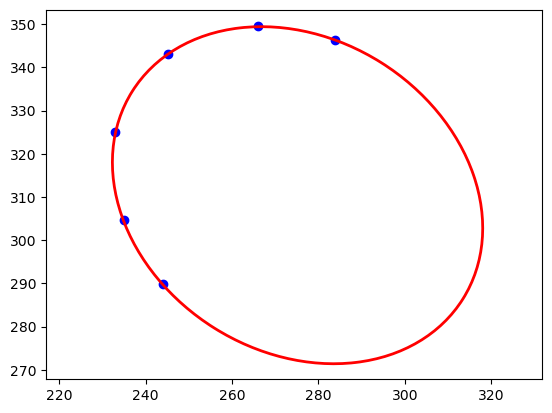

In [40]:
# Create a plot
fig, ax = plt.subplots()

row = 0
# Scatter plot of points
ax.scatter(Xs[row][:,0], Xs[row][:,1], color="blue", label="Points")
ellipse = Ellipse(xy=(ellipse_df.center_x[row], ellipse_df.center_y[row]),width= 2*ellipse_df.width[row], height = 2*ellipse_df.height[row], 
                  angle = np.degrees(ellipse_df.phi[row]), edgecolor="red", facecolor="none", lw=2)
ax.add_patch(ellipse)
plt.axis('equal')




In [37]:
np.degrees(ellipse_df.phi[1])


-37.05784139422994

In [46]:
print(len(Xs))
print(ellipse_df.shape)

705527
(705527, 6)


In [25]:
ellipse_df.to_csv(f'W:\Large_scale_mapping_NP\lizards\PV35\PV35_Experiment_18_8_24\Insertion2\PV35_2_Eye_ellipse_thr_{uncertainty_thr}.csv', index=False)

In [40]:
ellipse_df = pd.read_csv(r'PV35_2.csv')
ellipse_df

,center_x,center_y,width,height,phi,ellipse_size
0,480.334147,123.008915,40.713021,33.056247,-0.649406,4228.017228
1,480.296511,122.970827,40.711358,33.083265,-0.646781,4231.300118
2,480.337608,122.649134,40.839759,33.143213,-0.664699,4252.336673
3,480.336915,122.648994,40.840327,33.142868,-0.664609,4252.351734
4,480.336915,122.648994,40.840327,33.142868,-0.664609,4252.351734
...,...,...,...,...,...,...
705522,497.617510,122.280954,40.867977,30.836083,-0.740371,3959.061210
705523,497.620294,122.281806,40.866137,30.836554,-0.740364,3958.943466
705524,497.484265,122.175140,40.848169,30.877330,-0.732031,3962.435542
705525,497.591312,122.249793,40.876816,30.839999,-0.739898,3960.420340


In [46]:
pathvid = r'C:\Users\MarkS9\Desktop\HeadFixedEyeTrack2-Simon-2024-10-02\EyeTracking3-Simon-2024-10-03\videos\pv35_Insertion2_Camera1_20240819-123015DLC_Resnet50_EyeTracking3Oct3shuffle1_snapshot_200_p60_labeled.mp4'

In [42]:
def play_video_with_ellipses_rotation(ellipse_dataframe,path_to_video=True, xflip=False, transformation_matrix=None, phi_in_radians=False):

    if path_to_video is not False:
        video_path = path_to_video

   # pdb.set_trace()

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.loc[ellipse_dataframe.index == current_frame_num].index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        if transformation_matrix is not None:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
                
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue
        else:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
        
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()

In [47]:
play_video_with_ellipses_rotation(ellipse_df,pathvid)

KeyboardInterrupt: 

In [44]:
pathvid

'C:\\Users\\MarkS9\\Desktop\\Videos_trainingDLC\\pv35_Insertion2_Camera1_20240819-123015DLC_Resnet50_EyeTracking3Oct3shuffle1_snapshot_200_p60_labeled.mp4'